In [1]:
import os
from os.path import join
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import gc
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")


# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# EDA & Cleaning

In [ ]:
df=pd.read_pickle("LSWMD.pkl")

def removebrackets(array):
    if array.shape == (1, 1):
        return "".join(array[0])
    elif array.shape == (0, 0):
        return None
        
df.rename(columns = {'trianTestLabel':'TrainTestLabel'}, inplace = 'True')
df['TrainTestLabel'] = df['TrainTestLabel'].apply(removebrackets)
df['failureType'] = df['failureType'].apply(removebrackets)

df.info()

In [ ]:
df.sample(10)

In [ ]:
df.isna().sum()

In [ ]:
df_ = df.TrainTestLabel.dropna()
# df_ = df_.failureType.dropna()
df_

* The dataset were collected from **47,543 lots** in real-world fab. However, **47,543 lots x 25 wafer/lot =1,157,325 wafer maps** is larger than **811,457 wafer maps**. 

* Let's see what happened. 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0], uni_Index[1], align='center', alpha=0.5)
plt.title("wafer Index Distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [ ]:
df = df.drop(['waferIndex'], axis = 1)

* We can not get much information from the wafer map column but we can see the die size for each instance is different. 

* We create a new variable **'waferMapDim'** for wafer map dim checking.

In [ ]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0, dim1
    
df['waferMapDim']=df.waferMap.apply(find_dim)

In [ ]:
df.sample(5)

In [ ]:
df.info()

In [ ]:
df.shape[0]
# failureType: 811457 -> 172950

In [ ]:
df

In [ ]:
df_ = df.dropna(subset=['failureType'])

In [ ]:
df_

In [ ]:
max(df.waferMapDim), min(df.waferMapDim)

In [ ]:
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]
# 632개의 서로다른 Wafer map size 가 존재.

In [ ]:
df.groupby("waferMapDim").size().sort_values(ascending=False)[:20]

* The dimension of wafer map, or saying the **image size** are not always the same. We noticed that there are **632** different size for our wafer map. 

* For this reason, we must do **data tranformation** (feature extraction) to **make input the same dim** and the method will be introduced in the following section.

>**Missing value check**
* Do not be afraid to handle so large dataset. When you look into the dataset you may notice quite number of data are useless due to **missing values**.

* Do missing value check is an important part during data preparing process. Since we only interested in wafer with patterns, we may remove those data without failure type labels. 

In [ ]:
df['failureNum']=df.failureType
df['trainTestNum']=df.TrainTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [ ]:
df

In [ ]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

In [ ]:
df_withlabel

In [ ]:
df_withpattern

In [ ]:
df_nonpattern
# failuretype: none

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
no_wafers=[df.shape[0]-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

In [ ]:
# with labeled - failuretype
label = df_withlabel.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

In [ ]:
label = df_withpattern.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

In [ ]:
df_withpattern.failureType.value_counts()

In [ ]:
df_withpattern.waferMapDim[0][0]

In [ ]:
def find_size(x):
    w = x[0]
    h = x[1]
    return np.sqrt(w*h)
    
df_withlabel['wafermaplen'] = df_withlabel.waferMapDim.apply(find_size)

In [ ]:
print(df_withlabel.wafermaplen.median())
print(df_withlabel.wafermaplen.mean())

In [ ]:
plt.hist(df_withlabel.wafermaplen, bins=20)
plt.show()

## Visualize

In [ ]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withlabel.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withlabel.failureType[i], fontsize=10)
    ax[i].set_xlabel(df_withlabel.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [ ]:
x = [0,1,2,3,4,5,6,7,8]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','none']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_withlabel.waferMap[df_withlabel.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_withlabel.failureType[img.index[i]], fontsize=10)
            ax[i].set_xlabel(df_withlabel.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [ ]:
df_withlabel.waferMap.values[0]

In [ ]:
df_withlabel.failureNum.values

In [ ]:
X = df_withlabel.waferMap.values
y = df_withlabel.failureNum.values
assert X.shape[0] == y.shape[0]

In [ ]:
df_withlabel.failureNum.unique()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

# train, val, test = 0.7, 0.15, 0.15

In [ ]:
# Save
# torch.save(X_train, 'Data/X_train.pt')
# torch.save(X_val, 'Data/X_val.pt')
# torch.save(X_test, 'Data/X_test.pt')
# torch.save(y_train, 'Data/y_train.pt')
# torch.save(y_val, 'Data/y_val.pt')
# torch.save(y_test, 'Data/y_test.pt')

# Config

In [2]:
# Load
X_train = torch.load('Data/X_train_new.pt')
X_val = torch.load('Data/X_val_new.pt')
X_test = torch.load('Data/X_test_new.pt')
y_train = torch.load('Data/y_train_new.pt')
y_val = torch.load('Data/y_val_new.pt')
y_test = torch.load('Data/y_test_new.pt')

In [3]:
BATCH_SIZE_TRAIN = 256  # 32 -> 256
BATCH_SIZE_VAL = 512
BATCH_SIZE_TEST = 512

RE_SIZE = 96
INPUT_CH = 1    # Must be 1
NUM_CLASSES = 9
IS_PRETRAINED = False
LEARNING_RATE = 1e-4
EPOCHS = 80

save_name = f'resnet50_batch{BATCH_SIZE_TRAIN}_aug'
save_path = f'models/{save_name}.pt'
device = torch.device("cuda:0")
print(save_name, save_path)

resnet50_batch256_aug models/resnet50_batch256_aug.pt


# Dataset

In [4]:
from albumentations.pytorch.transforms import ToTensorV2
from utils import get_transforms, display_aug
# Transforms and Dataset

class WaferDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        # X = self.df.waferMap.values[idx]
        # y = self.df.failureNum.values[idx].int()

        if self.transform:
            X = self.transform(image=X)
            
        return {
            'img' : X['image'], 
            'label': y
        }

train_transform, else_transform = get_transforms(size=RE_SIZE)

train_dataset = WaferDataset(X_train, y_train, transform=train_transform)
val_dataset = WaferDataset(X_val, y_val, transform=else_transform)
test_dataset = WaferDataset(X_test, y_test, transform=else_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

print(len(train_dataset), len(val_dataset), len(test_dataset))

24863 5328 5328


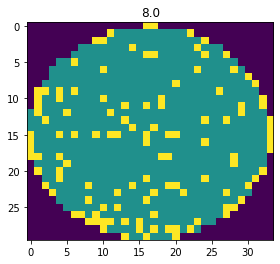

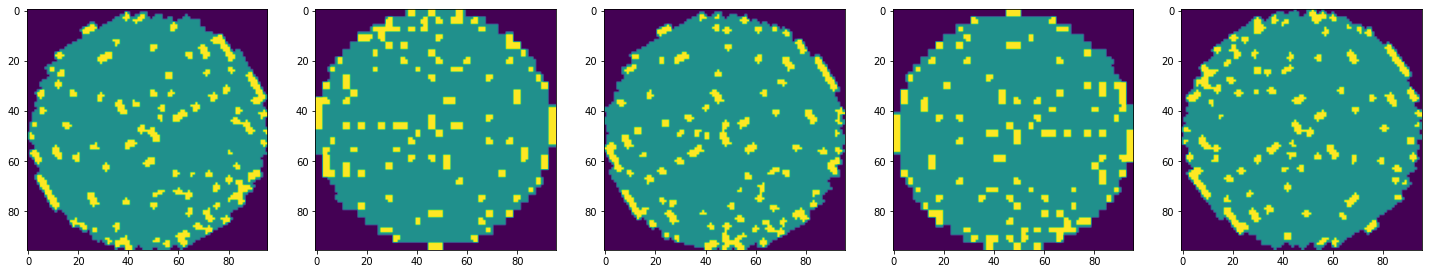

In [5]:
display_aug(imgs=X_train, transform=train_transform, labels = y_train)

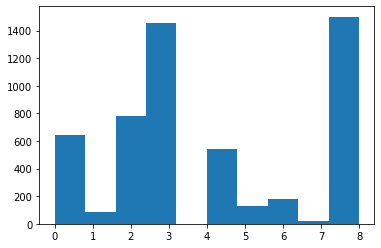

In [6]:
plt.hist(y_test)
plt.show()

# Model

In [7]:
from torchvision.models import resnet50
from torchinfo import summary

model = resnet50(pretrained=IS_PRETRAINED)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)
# summary(model, (BATCH_SIZE_TRAIN, INPUT_CH, RE_SIZE, RE_SIZE), device='cpu')

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(reduction='mean')
# criterion = FocalLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, threshold=0.1, patience=5, cooldown=3, threshold_mode='rel', verbose=True)

In [9]:
from sklearn.metrics import f1_score 

def train(model, loader, epoch, nb_epochs):
    running_loss, running_corrects, running_num = 0.0, 0, 0
    y_true, y_pred = [], []
    # scaler = torch.cuda.amp.GradScaler()
    tqdm_loader = tqdm(enumerate(loader))
    model.train()
    for batch_idx, batch in tqdm_loader:
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # # mixed precision + gradient clipping
        # with torch.cuda.amp.autocast():
        #     output = model(img)
        #     loss = criterion(output, label)

        # scaler.scale(loss).backward() 
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        # scaler.step(optimizer)
        # scaler.update()
        
        # forward + backward + optimize
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        # stats
        preds = torch.argmax(output, dim=1)
        correct = torch.eq(preds, label).sum()
        running_loss += loss.item() 
        running_corrects += correct
        running_num += len(label)
        
        for item in label.cpu().numpy():
            y_true.append(item)
        for item in preds.cpu().numpy():
            y_pred.append(item)
        
        tqdm_loader.set_postfix({
            'Epoch': '{}/{}'.format(epoch + 1, nb_epochs),
            'Batch' : '{}/{}'.format(batch_idx + 1, len(loader)),
            'Batch Loss': '{:06f}'.format(loss.item()),
            'Mean Loss' : '{:06f}'.format(running_loss / (batch_idx + 1)),
            'Batch ACC': '{:06f}'.format(correct / len(label)),
            'Mean ACC' : '{:06f}'.format(running_corrects / running_num)
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = running_corrects / running_num
    epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
    epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')

    writer.add_scalar('Loss/Train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
    writer.add_scalar('F1_macro/Train', epoch_f1_macro, epoch)
    writer.add_scalar('F1_weighted/Train', epoch_f1_weighted, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f} lr: {optimizer.param_groups[0]["lr"]:.6f}')
    
def evaluate(model, loader, epoch, nb_epochs):
    running_loss, running_corrects, running_num = 0.0, 0, 0
    y_true, y_pred = [], []
    tqdm_loader = tqdm(enumerate(loader))
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in tqdm_loader:
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)#.long().to(device)

            output = model(img)
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_loss += loss.item() 
            running_corrects += correct
            running_num += len(label)

            for item in label.cpu().numpy():
                y_true.append(item)
            for item in preds.cpu().numpy():
                y_pred.append(item)

            tqdm_loader.set_postfix({
                'Epoch': '{}/{}'.format(epoch + 1, nb_epochs),
                'Batch' : '{}/{}'.format(batch_idx + 1, len(loader)),
                'Batch Loss': '{:06f}'.format(loss.item()),
                'Mean Loss' : '{:06f}'.format(running_loss / (batch_idx + 1)),
                'Batch ACC': '{:06f}'.format(correct / len(label)),
                'Mean ACC' : '{:06f}'.format(running_corrects / running_num)
            })

        epoch_loss = running_loss / len(loader)
        epoch_acc = running_corrects / running_num
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        scheduler.step(epoch_loss)
        
        writer.add_scalar('Loss/Valid', epoch_loss, epoch)
        writer.add_scalar('Accuracy/Valid', epoch_acc, epoch)
        writer.add_scalar('F1_macro/Valid', epoch_f1_macro, epoch)
        writer.add_scalar('F1_weighted/Valid', epoch_f1_weighted, epoch)
        
        print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')
        print(f'{running_corrects}/{running_num} correct')
        
        epoch_acc = epoch_acc.detach().cpu().numpy()    # tensor->numpy
        val_acc_list.append(epoch_acc)
        val_f1_macro_list.append(epoch_f1_macro)
        val_f1_weighted_list.append(epoch_f1_weighted)
        
        if np.max(val_f1_macro_list) == val_f1_macro_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            torch.save(model.state_dict(), save_path)   # weighted F1 기준


# Train

In [10]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/' + save_name)

val_acc_list = []
val_f1_macro_list = []
val_f1_weighted_list = []

model.to(device)

for epoch in range(EPOCHS):
    train(model, train_loader, epoch, EPOCHS)
    evaluate(model, val_loader, epoch, EPOCHS)

98it [00:19,  5.08it/s, Epoch=1/80, Batch=98/98, Batch Loss=1.126457, Mean Loss=1.096696, Batch ACC=0.645161, Mean ACC=0.617786]


Train loss: 1.096696, Train ACC: 0.617786, F1_macro: 0.402065, F1_weighted: 0.563109 lr: 0.000100


11it [00:01, 10.80it/s, Epoch=1/80, Batch=11/11, Batch Loss=1.042349, Mean Loss=0.935740, Batch ACC=0.673077, Mean ACC=0.703641]


Valid loss: 0.935740, Valid ACC: 0.703641, F1_macro: 0.431180, F1_weighted: 0.667365
3749/5328 correct


98it [00:16,  5.95it/s, Epoch=2/80, Batch=98/98, Batch Loss=0.644827, Mean Loss=0.676956, Batch ACC=0.774194, Mean ACC=0.768210]


Train loss: 0.676956, Train ACC: 0.768210, F1_macro: 0.633361, F1_weighted: 0.747566 lr: 0.000100


11it [00:01, 10.59it/s, Epoch=2/80, Batch=11/11, Batch Loss=0.650493, Mean Loss=0.600289, Batch ACC=0.735577, Mean ACC=0.789414]


Valid loss: 0.600289, Valid ACC: 0.789414, F1_macro: 0.654832, F1_weighted: 0.778547
4206/5328 correct


98it [00:16,  5.93it/s, Epoch=3/80, Batch=98/98, Batch Loss=0.703558, Mean Loss=0.530946, Batch ACC=0.741935, Mean ACC=0.817721]


Train loss: 0.530946, Train ACC: 0.817721, F1_macro: 0.706886, F1_weighted: 0.801565 lr: 0.000100


11it [00:01, 10.46it/s, Epoch=3/80, Batch=11/11, Batch Loss=0.505549, Mean Loss=0.475816, Batch ACC=0.850962, Mean ACC=0.841404]


Valid loss: 0.475816, Valid ACC: 0.841404, F1_macro: 0.718246, F1_weighted: 0.823469
4483/5328 correct


98it [00:16,  5.99it/s, Epoch=4/80, Batch=98/98, Batch Loss=0.488027, Mean Loss=0.439569, Batch ACC=0.774194, Mean ACC=0.848289]


Train loss: 0.439569, Train ACC: 0.848289, F1_macro: 0.733236, F1_weighted: 0.834565 lr: 0.000100


11it [00:01, 10.84it/s, Epoch=4/80, Batch=11/11, Batch Loss=0.485616, Mean Loss=0.411920, Batch ACC=0.831731, Mean ACC=0.857920]


Valid loss: 0.411920, Valid ACC: 0.857920, F1_macro: 0.758805, F1_weighted: 0.846026
4571/5328 correct


98it [00:16,  6.04it/s, Epoch=5/80, Batch=98/98, Batch Loss=0.828738, Mean Loss=0.395582, Batch ACC=0.774194, Mean ACC=0.863934]


Train loss: 0.395582, Train ACC: 0.863934, F1_macro: 0.762138, F1_weighted: 0.852888 lr: 0.000100


11it [00:01,  9.85it/s, Epoch=5/80, Batch=11/11, Batch Loss=0.515101, Mean Loss=0.411544, Batch ACC=0.812500, Mean ACC=0.859422]


Valid loss: 0.411544, Valid ACC: 0.859422, F1_macro: 0.739449, F1_weighted: 0.852351
4579/5328 correct


98it [00:16,  5.96it/s, Epoch=6/80, Batch=98/98, Batch Loss=0.209889, Mean Loss=0.361039, Batch ACC=0.935484, Mean ACC=0.872300]


Train loss: 0.361039, Train ACC: 0.872300, F1_macro: 0.772950, F1_weighted: 0.863038 lr: 0.000100


11it [00:01, 10.19it/s, Epoch=6/80, Batch=11/11, Batch Loss=0.423663, Mean Loss=0.336764, Batch ACC=0.850962, Mean ACC=0.882695]


Valid loss: 0.336764, Valid ACC: 0.882695, F1_macro: 0.789231, F1_weighted: 0.874047
4703/5328 correct


98it [00:16,  5.89it/s, Epoch=7/80, Batch=98/98, Batch Loss=0.383836, Mean Loss=0.325857, Batch ACC=0.935484, Mean ACC=0.885050]


Train loss: 0.325857, Train ACC: 0.885050, F1_macro: 0.798340, F1_weighted: 0.877653 lr: 0.000100


11it [00:01, 10.52it/s, Epoch=7/80, Batch=11/11, Batch Loss=0.401110, Mean Loss=0.316617, Batch ACC=0.884615, Mean ACC=0.889077]


Valid loss: 0.316617, Valid ACC: 0.889077, F1_macro: 0.802597, F1_weighted: 0.880905
4737/5328 correct


98it [00:16,  5.92it/s, Epoch=8/80, Batch=98/98, Batch Loss=0.157994, Mean Loss=0.304722, Batch ACC=0.967742, Mean ACC=0.890681]


Train loss: 0.304722, Train ACC: 0.890681, F1_macro: 0.804854, F1_weighted: 0.883986 lr: 0.000100


11it [00:01, 10.67it/s, Epoch=8/80, Batch=11/11, Batch Loss=0.386198, Mean Loss=0.313809, Batch ACC=0.884615, Mean ACC=0.889264]


Valid loss: 0.313809, Valid ACC: 0.889264, F1_macro: 0.806949, F1_weighted: 0.881779
4738/5328 correct


98it [00:16,  5.94it/s, Epoch=9/80, Batch=98/98, Batch Loss=0.165420, Mean Loss=0.297025, Batch ACC=0.967742, Mean ACC=0.894019]


Train loss: 0.297025, Train ACC: 0.894019, F1_macro: 0.820202, F1_weighted: 0.888201 lr: 0.000100


11it [00:01, 10.53it/s, Epoch=9/80, Batch=11/11, Batch Loss=0.415559, Mean Loss=0.310148, Batch ACC=0.875000, Mean ACC=0.894707]


Valid loss: 0.310148, Valid ACC: 0.894707, F1_macro: 0.806520, F1_weighted: 0.887294
4767/5328 correct


98it [00:16,  6.06it/s, Epoch=10/80, Batch=98/98, Batch Loss=0.288761, Mean Loss=0.288072, Batch ACC=0.903226, Mean ACC=0.897720]


Train loss: 0.288072, Train ACC: 0.897720, F1_macro: 0.829475, F1_weighted: 0.892929 lr: 0.000100


11it [00:01, 10.73it/s, Epoch=10/80, Batch=11/11, Batch Loss=0.385947, Mean Loss=0.288757, Batch ACC=0.894231, Mean ACC=0.900901]


Valid loss: 0.288757, Valid ACC: 0.900901, F1_macro: 0.830976, F1_weighted: 0.894771
4800/5328 correct


98it [00:16,  6.00it/s, Epoch=11/80, Batch=98/98, Batch Loss=0.234446, Mean Loss=0.277174, Batch ACC=0.935484, Mean ACC=0.900294]


Train loss: 0.277174, Train ACC: 0.900294, F1_macro: 0.831108, F1_weighted: 0.896123 lr: 0.000100


11it [00:01, 10.58it/s, Epoch=11/80, Batch=11/11, Batch Loss=0.344219, Mean Loss=0.283171, Batch ACC=0.889423, Mean ACC=0.899399]


Valid loss: 0.283171, Valid ACC: 0.899399, F1_macro: 0.851401, F1_weighted: 0.896166
4792/5328 correct


98it [00:16,  6.01it/s, Epoch=12/80, Batch=98/98, Batch Loss=0.206176, Mean Loss=0.255757, Batch ACC=0.870968, Mean ACC=0.906286]


Train loss: 0.255757, Train ACC: 0.906286, F1_macro: 0.846470, F1_weighted: 0.902470 lr: 0.000100


11it [00:01, 10.84it/s, Epoch=12/80, Batch=11/11, Batch Loss=0.356154, Mean Loss=0.270721, Batch ACC=0.875000, Mean ACC=0.902402]


Valid loss: 0.270721, Valid ACC: 0.902402, F1_macro: 0.829768, F1_weighted: 0.896691
4808/5328 correct


98it [00:15,  6.14it/s, Epoch=13/80, Batch=98/98, Batch Loss=0.269452, Mean Loss=0.253979, Batch ACC=0.838710, Mean ACC=0.908056]


Train loss: 0.253979, Train ACC: 0.908056, F1_macro: 0.851871, F1_weighted: 0.905099 lr: 0.000100


11it [00:01, 10.49it/s, Epoch=13/80, Batch=11/11, Batch Loss=0.331611, Mean Loss=0.274602, Batch ACC=0.884615, Mean ACC=0.902590]


Valid loss: 0.274602, Valid ACC: 0.902590, F1_macro: 0.838529, F1_weighted: 0.898149
4809/5328 correct


98it [00:16,  6.08it/s, Epoch=14/80, Batch=98/98, Batch Loss=0.226994, Mean Loss=0.253021, Batch ACC=0.870968, Mean ACC=0.909504]


Train loss: 0.253021, Train ACC: 0.909504, F1_macro: 0.849226, F1_weighted: 0.906683 lr: 0.000100


11it [00:01, 10.85it/s, Epoch=14/80, Batch=11/11, Batch Loss=0.319238, Mean Loss=0.256622, Batch ACC=0.889423, Mean ACC=0.906344]


Valid loss: 0.256622, Valid ACC: 0.906344, F1_macro: 0.847228, F1_weighted: 0.903587
4829/5328 correct


98it [00:16,  5.96it/s, Epoch=15/80, Batch=98/98, Batch Loss=0.050027, Mean Loss=0.238235, Batch ACC=1.000000, Mean ACC=0.913566]


Train loss: 0.238235, Train ACC: 0.913566, F1_macro: 0.862152, F1_weighted: 0.911284 lr: 0.000100


11it [00:00, 11.00it/s, Epoch=15/80, Batch=11/11, Batch Loss=0.361956, Mean Loss=0.269143, Batch ACC=0.865385, Mean ACC=0.902965]


Valid loss: 0.269143, Valid ACC: 0.902965, F1_macro: 0.838777, F1_weighted: 0.898058
4811/5328 correct


98it [00:15,  6.23it/s, Epoch=16/80, Batch=98/98, Batch Loss=0.090519, Mean Loss=0.240122, Batch ACC=0.967742, Mean ACC=0.913124]


Train loss: 0.240122, Train ACC: 0.913124, F1_macro: 0.855473, F1_weighted: 0.910765 lr: 0.000100


11it [00:01, 10.61it/s, Epoch=16/80, Batch=11/11, Batch Loss=0.323109, Mean Loss=0.276641, Batch ACC=0.903846, Mean ACC=0.904467]


Valid loss: 0.276641, Valid ACC: 0.904467, F1_macro: 0.822677, F1_weighted: 0.901276
4819/5328 correct


98it [00:15,  6.26it/s, Epoch=17/80, Batch=98/98, Batch Loss=0.229051, Mean Loss=0.229420, Batch ACC=0.903226, Mean ACC=0.918795]


Train loss: 0.229420, Train ACC: 0.918795, F1_macro: 0.864847, F1_weighted: 0.916868 lr: 0.000100


11it [00:01, 10.89it/s, Epoch=17/80, Batch=11/11, Batch Loss=0.317019, Mean Loss=0.259132, Batch ACC=0.899038, Mean ACC=0.912913]


Valid loss: 0.259132, Valid ACC: 0.912913, F1_macro: 0.850925, F1_weighted: 0.911788
4864/5328 correct


98it [00:16,  6.08it/s, Epoch=18/80, Batch=98/98, Batch Loss=0.264070, Mean Loss=0.228465, Batch ACC=0.870968, Mean ACC=0.917508]


Train loss: 0.228465, Train ACC: 0.917508, F1_macro: 0.870290, F1_weighted: 0.915735 lr: 0.000100


11it [00:01, 10.37it/s, Epoch=18/80, Batch=11/11, Batch Loss=0.278494, Mean Loss=0.280706, Batch ACC=0.908654, Mean ACC=0.901652]


Valid loss: 0.280706, Valid ACC: 0.901652, F1_macro: 0.844283, F1_weighted: 0.901013
4804/5328 correct


98it [00:15,  6.18it/s, Epoch=19/80, Batch=98/98, Batch Loss=0.344287, Mean Loss=0.221608, Batch ACC=0.903226, Mean ACC=0.921450]


Train loss: 0.221608, Train ACC: 0.921450, F1_macro: 0.877812, F1_weighted: 0.919887 lr: 0.000100


11it [00:01, 10.59it/s, Epoch=19/80, Batch=11/11, Batch Loss=0.303006, Mean Loss=0.256493, Batch ACC=0.870192, Mean ACC=0.911974]


Valid loss: 0.256493, Valid ACC: 0.911974, F1_macro: 0.846190, F1_weighted: 0.907247
4859/5328 correct


98it [00:15,  6.17it/s, Epoch=20/80, Batch=98/98, Batch Loss=0.072624, Mean Loss=0.214692, Batch ACC=1.000000, Mean ACC=0.923099]


Train loss: 0.214692, Train ACC: 0.923099, F1_macro: 0.876221, F1_weighted: 0.921605 lr: 0.000100


11it [00:01, 10.62it/s, Epoch=20/80, Batch=11/11, Batch Loss=0.276101, Mean Loss=0.272455, Batch ACC=0.894231, Mean ACC=0.902590]


Epoch    20: reducing learning rate of group 0 to 5.0000e-05.
Valid loss: 0.272455, Valid ACC: 0.902590, F1_macro: 0.853199, F1_weighted: 0.901948
4809/5328 correct


98it [00:16,  6.08it/s, Epoch=21/80, Batch=98/98, Batch Loss=0.528126, Mean Loss=0.200673, Batch ACC=0.870968, Mean ACC=0.927282]


Train loss: 0.200673, Train ACC: 0.927282, F1_macro: 0.890968, F1_weighted: 0.926257 lr: 0.000050


11it [00:01, 10.86it/s, Epoch=21/80, Batch=11/11, Batch Loss=0.244072, Mean Loss=0.228552, Batch ACC=0.923077, Mean ACC=0.916479]


Valid loss: 0.228552, Valid ACC: 0.916479, F1_macro: 0.865038, F1_weighted: 0.914720
4883/5328 correct


98it [00:15,  6.15it/s, Epoch=22/80, Batch=98/98, Batch Loss=0.279913, Mean Loss=0.190867, Batch ACC=0.935484, Mean ACC=0.932470]


Train loss: 0.190867, Train ACC: 0.932470, F1_macro: 0.892689, F1_weighted: 0.931361 lr: 0.000050


11it [00:01, 10.75it/s, Epoch=22/80, Batch=11/11, Batch Loss=0.248251, Mean Loss=0.233073, Batch ACC=0.918269, Mean ACC=0.915353]


Valid loss: 0.233073, Valid ACC: 0.915353, F1_macro: 0.877218, F1_weighted: 0.913707
4877/5328 correct


98it [00:15,  6.15it/s, Epoch=23/80, Batch=98/98, Batch Loss=0.136446, Mean Loss=0.186185, Batch ACC=0.935484, Mean ACC=0.935084]


Train loss: 0.186185, Train ACC: 0.935084, F1_macro: 0.899540, F1_weighted: 0.934160 lr: 0.000050


11it [00:01, 10.70it/s, Epoch=23/80, Batch=11/11, Batch Loss=0.275112, Mean Loss=0.232988, Batch ACC=0.903846, Mean ACC=0.919670]


Valid loss: 0.232988, Valid ACC: 0.919670, F1_macro: 0.877513, F1_weighted: 0.918312
4900/5328 correct


98it [00:15,  6.13it/s, Epoch=24/80, Batch=98/98, Batch Loss=0.117781, Mean Loss=0.179222, Batch ACC=0.935484, Mean ACC=0.936975]


Train loss: 0.179222, Train ACC: 0.936975, F1_macro: 0.902924, F1_weighted: 0.936066 lr: 0.000050


11it [00:01, 10.88it/s, Epoch=24/80, Batch=11/11, Batch Loss=0.234678, Mean Loss=0.228211, Batch ACC=0.923077, Mean ACC=0.918544]


Valid loss: 0.228211, Valid ACC: 0.918544, F1_macro: 0.872491, F1_weighted: 0.917568
4894/5328 correct


98it [00:15,  6.19it/s, Epoch=25/80, Batch=98/98, Batch Loss=0.115827, Mean Loss=0.181197, Batch ACC=0.967742, Mean ACC=0.935165]


Train loss: 0.181197, Train ACC: 0.935165, F1_macro: 0.899122, F1_weighted: 0.934308 lr: 0.000050


11it [00:00, 11.00it/s, Epoch=25/80, Batch=11/11, Batch Loss=0.250865, Mean Loss=0.218295, Batch ACC=0.908654, Mean ACC=0.921922]


Valid loss: 0.218295, Valid ACC: 0.921922, F1_macro: 0.878894, F1_weighted: 0.921360
4912/5328 correct


98it [00:15,  6.21it/s, Epoch=26/80, Batch=98/98, Batch Loss=0.100095, Mean Loss=0.174714, Batch ACC=0.967742, Mean ACC=0.939227]


Train loss: 0.174714, Train ACC: 0.939227, F1_macro: 0.911864, F1_weighted: 0.938510 lr: 0.000050


11it [00:01, 10.94it/s, Epoch=26/80, Batch=11/11, Batch Loss=0.259486, Mean Loss=0.220095, Batch ACC=0.908654, Mean ACC=0.918544]


Valid loss: 0.220095, Valid ACC: 0.918544, F1_macro: 0.874318, F1_weighted: 0.917271
4894/5328 correct


98it [00:15,  6.21it/s, Epoch=27/80, Batch=98/98, Batch Loss=0.194276, Mean Loss=0.171715, Batch ACC=0.935484, Mean ACC=0.939669]


Train loss: 0.171715, Train ACC: 0.939669, F1_macro: 0.912354, F1_weighted: 0.938947 lr: 0.000050


11it [00:00, 11.02it/s, Epoch=27/80, Batch=11/11, Batch Loss=0.259174, Mean Loss=0.224409, Batch ACC=0.899038, Mean ACC=0.917042]


Valid loss: 0.224409, Valid ACC: 0.917042, F1_macro: 0.866485, F1_weighted: 0.914810
4886/5328 correct


98it [00:15,  6.23it/s, Epoch=28/80, Batch=98/98, Batch Loss=0.414165, Mean Loss=0.174635, Batch ACC=0.903226, Mean ACC=0.937658]


Train loss: 0.174635, Train ACC: 0.937658, F1_macro: 0.903137, F1_weighted: 0.936833 lr: 0.000050


11it [00:01, 11.00it/s, Epoch=28/80, Batch=11/11, Batch Loss=0.251177, Mean Loss=0.218729, Batch ACC=0.908654, Mean ACC=0.923423]


Valid loss: 0.218729, Valid ACC: 0.923423, F1_macro: 0.882182, F1_weighted: 0.922591
4920/5328 correct


98it [00:15,  6.13it/s, Epoch=29/80, Batch=98/98, Batch Loss=0.110035, Mean Loss=0.165096, Batch ACC=0.935484, Mean ACC=0.943048]


Train loss: 0.165096, Train ACC: 0.943048, F1_macro: 0.912155, F1_weighted: 0.942589 lr: 0.000050


11it [00:01, 10.95it/s, Epoch=29/80, Batch=11/11, Batch Loss=0.264221, Mean Loss=0.217596, Batch ACC=0.913462, Mean ACC=0.924362]


Epoch    29: reducing learning rate of group 0 to 2.5000e-05.
Valid loss: 0.217596, Valid ACC: 0.924362, F1_macro: 0.881266, F1_weighted: 0.923399
4925/5328 correct


98it [00:15,  6.17it/s, Epoch=30/80, Batch=98/98, Batch Loss=0.100097, Mean Loss=0.159341, Batch ACC=1.000000, Mean ACC=0.943571]


Train loss: 0.159341, Train ACC: 0.943571, F1_macro: 0.918412, F1_weighted: 0.943065 lr: 0.000025


11it [00:00, 11.02it/s, Epoch=30/80, Batch=11/11, Batch Loss=0.270918, Mean Loss=0.214357, Batch ACC=0.908654, Mean ACC=0.923611]


Valid loss: 0.214357, Valid ACC: 0.923611, F1_macro: 0.882079, F1_weighted: 0.922378
4921/5328 correct


98it [00:16,  6.11it/s, Epoch=31/80, Batch=98/98, Batch Loss=0.257597, Mean Loss=0.149466, Batch ACC=0.935484, Mean ACC=0.950006]


Train loss: 0.149466, Train ACC: 0.950006, F1_macro: 0.923736, F1_weighted: 0.949542 lr: 0.000025


11it [00:01, 10.68it/s, Epoch=31/80, Batch=11/11, Batch Loss=0.258227, Mean Loss=0.211725, Batch ACC=0.918269, Mean ACC=0.922485]


Valid loss: 0.211725, Valid ACC: 0.922485, F1_macro: 0.875056, F1_weighted: 0.921887
4915/5328 correct


98it [00:16,  5.92it/s, Epoch=32/80, Batch=98/98, Batch Loss=0.080130, Mean Loss=0.150019, Batch ACC=0.967742, Mean ACC=0.947271]


Train loss: 0.150019, Train ACC: 0.947271, F1_macro: 0.921176, F1_weighted: 0.946809 lr: 0.000025


11it [00:01, 10.54it/s, Epoch=32/80, Batch=11/11, Batch Loss=0.238634, Mean Loss=0.207266, Batch ACC=0.918269, Mean ACC=0.924362]


Valid loss: 0.207266, Valid ACC: 0.924362, F1_macro: 0.884323, F1_weighted: 0.923017
4925/5328 correct


98it [00:16,  5.93it/s, Epoch=33/80, Batch=98/98, Batch Loss=0.054622, Mean Loss=0.149373, Batch ACC=0.967742, Mean ACC=0.949202]


Train loss: 0.149373, Train ACC: 0.949202, F1_macro: 0.925344, F1_weighted: 0.948896 lr: 0.000025


11it [00:01, 10.42it/s, Epoch=33/80, Batch=11/11, Batch Loss=0.266139, Mean Loss=0.220032, Batch ACC=0.927885, Mean ACC=0.925488]


Valid loss: 0.220032, Valid ACC: 0.925488, F1_macro: 0.883640, F1_weighted: 0.924058
4931/5328 correct


98it [00:16,  5.99it/s, Epoch=34/80, Batch=98/98, Batch Loss=0.099588, Mean Loss=0.147849, Batch ACC=0.967742, Mean ACC=0.950247]


Train loss: 0.147849, Train ACC: 0.950247, F1_macro: 0.923912, F1_weighted: 0.949813 lr: 0.000025


11it [00:01, 10.64it/s, Epoch=34/80, Batch=11/11, Batch Loss=0.251651, Mean Loss=0.207327, Batch ACC=0.903846, Mean ACC=0.926426]


Valid loss: 0.207327, Valid ACC: 0.926426, F1_macro: 0.884509, F1_weighted: 0.925105
4936/5328 correct


98it [00:16,  6.03it/s, Epoch=35/80, Batch=98/98, Batch Loss=0.598480, Mean Loss=0.152608, Batch ACC=0.838710, Mean ACC=0.949121]


Train loss: 0.152608, Train ACC: 0.949121, F1_macro: 0.927789, F1_weighted: 0.948798 lr: 0.000025


11it [00:01, 10.56it/s, Epoch=35/80, Batch=11/11, Batch Loss=0.238870, Mean Loss=0.209201, Batch ACC=0.923077, Mean ACC=0.926239]


Valid loss: 0.209201, Valid ACC: 0.926239, F1_macro: 0.890808, F1_weighted: 0.925836
4935/5328 correct


98it [00:16,  6.08it/s, Epoch=36/80, Batch=98/98, Batch Loss=0.065782, Mean Loss=0.144573, Batch ACC=0.967742, Mean ACC=0.949322]


Train loss: 0.144573, Train ACC: 0.949322, F1_macro: 0.924453, F1_weighted: 0.948840 lr: 0.000025


11it [00:01, 10.96it/s, Epoch=36/80, Batch=11/11, Batch Loss=0.248547, Mean Loss=0.207947, Batch ACC=0.913462, Mean ACC=0.924174]


Valid loss: 0.207947, Valid ACC: 0.924174, F1_macro: 0.878544, F1_weighted: 0.922754
4924/5328 correct


98it [00:15,  6.16it/s, Epoch=37/80, Batch=98/98, Batch Loss=0.111385, Mean Loss=0.145770, Batch ACC=0.967742, Mean ACC=0.949604]


Train loss: 0.145770, Train ACC: 0.949604, F1_macro: 0.926016, F1_weighted: 0.949212 lr: 0.000025


11it [00:01, 10.88it/s, Epoch=37/80, Batch=11/11, Batch Loss=0.240737, Mean Loss=0.200468, Batch ACC=0.899038, Mean ACC=0.926239]


Valid loss: 0.200468, Valid ACC: 0.926239, F1_macro: 0.880794, F1_weighted: 0.924836
4935/5328 correct


98it [00:15,  6.14it/s, Epoch=38/80, Batch=98/98, Batch Loss=0.077923, Mean Loss=0.138872, Batch ACC=0.967742, Mean ACC=0.951575]


Train loss: 0.138872, Train ACC: 0.951575, F1_macro: 0.928745, F1_weighted: 0.951263 lr: 0.000025


11it [00:01, 10.47it/s, Epoch=38/80, Batch=11/11, Batch Loss=0.247498, Mean Loss=0.206427, Batch ACC=0.913462, Mean ACC=0.927177]


Valid loss: 0.206427, Valid ACC: 0.927177, F1_macro: 0.887038, F1_weighted: 0.925800
4940/5328 correct


98it [00:16,  5.95it/s, Epoch=39/80, Batch=98/98, Batch Loss=0.150807, Mean Loss=0.137419, Batch ACC=0.935484, Mean ACC=0.953948]


Train loss: 0.137419, Train ACC: 0.953948, F1_macro: 0.931513, F1_weighted: 0.953574 lr: 0.000025


11it [00:01, 10.56it/s, Epoch=39/80, Batch=11/11, Batch Loss=0.271960, Mean Loss=0.216169, Batch ACC=0.899038, Mean ACC=0.923986]


Valid loss: 0.216169, Valid ACC: 0.923986, F1_macro: 0.883409, F1_weighted: 0.923091
4923/5328 correct


98it [00:16,  5.95it/s, Epoch=40/80, Batch=98/98, Batch Loss=0.039967, Mean Loss=0.139568, Batch ACC=1.000000, Mean ACC=0.951092]


Train loss: 0.139568, Train ACC: 0.951092, F1_macro: 0.924885, F1_weighted: 0.950785 lr: 0.000025


11it [00:01, 10.60it/s, Epoch=40/80, Batch=11/11, Batch Loss=0.229344, Mean Loss=0.205782, Batch ACC=0.903846, Mean ACC=0.926051]


Valid loss: 0.205782, Valid ACC: 0.926051, F1_macro: 0.884270, F1_weighted: 0.925257
4934/5328 correct


98it [00:16,  5.90it/s, Epoch=41/80, Batch=98/98, Batch Loss=0.140047, Mean Loss=0.140501, Batch ACC=0.935484, Mean ACC=0.951977]


Train loss: 0.140501, Train ACC: 0.951977, F1_macro: 0.931115, F1_weighted: 0.951701 lr: 0.000025


11it [00:01, 10.38it/s, Epoch=41/80, Batch=11/11, Batch Loss=0.257521, Mean Loss=0.204851, Batch ACC=0.903846, Mean ACC=0.925863]


Valid loss: 0.204851, Valid ACC: 0.925863, F1_macro: 0.880200, F1_weighted: 0.924636
4933/5328 correct


98it [00:16,  5.92it/s, Epoch=42/80, Batch=98/98, Batch Loss=0.251036, Mean Loss=0.138390, Batch ACC=0.935484, Mean ACC=0.953183]


Train loss: 0.138390, Train ACC: 0.953183, F1_macro: 0.931508, F1_weighted: 0.952917 lr: 0.000025


11it [00:01, 10.38it/s, Epoch=42/80, Batch=11/11, Batch Loss=0.252161, Mean Loss=0.211150, Batch ACC=0.899038, Mean ACC=0.925113]


Valid loss: 0.211150, Valid ACC: 0.925113, F1_macro: 0.888265, F1_weighted: 0.923433
4929/5328 correct


98it [00:16,  6.07it/s, Epoch=43/80, Batch=98/98, Batch Loss=0.092305, Mean Loss=0.137720, Batch ACC=0.967742, Mean ACC=0.954350]


Train loss: 0.137720, Train ACC: 0.954350, F1_macro: 0.934698, F1_weighted: 0.954034 lr: 0.000025


11it [00:01, 10.57it/s, Epoch=43/80, Batch=11/11, Batch Loss=0.246144, Mean Loss=0.208709, Batch ACC=0.913462, Mean ACC=0.925863]


Epoch    43: reducing learning rate of group 0 to 1.2500e-05.
Valid loss: 0.208709, Valid ACC: 0.925863, F1_macro: 0.884344, F1_weighted: 0.924878
4933/5328 correct


98it [00:16,  6.03it/s, Epoch=44/80, Batch=98/98, Batch Loss=0.341958, Mean Loss=0.134813, Batch ACC=0.903226, Mean ACC=0.955436]


Train loss: 0.134813, Train ACC: 0.955436, F1_macro: 0.934422, F1_weighted: 0.955160 lr: 0.000013


11it [00:01, 10.97it/s, Epoch=44/80, Batch=11/11, Batch Loss=0.231449, Mean Loss=0.202010, Batch ACC=0.894231, Mean ACC=0.926051]


Valid loss: 0.202010, Valid ACC: 0.926051, F1_macro: 0.887435, F1_weighted: 0.925099
4934/5328 correct


98it [00:15,  6.14it/s, Epoch=45/80, Batch=98/98, Batch Loss=0.255138, Mean Loss=0.132221, Batch ACC=0.870968, Mean ACC=0.954229]


Train loss: 0.132221, Train ACC: 0.954229, F1_macro: 0.933795, F1_weighted: 0.953866 lr: 0.000013


11it [00:01, 10.80it/s, Epoch=45/80, Batch=11/11, Batch Loss=0.226890, Mean Loss=0.197962, Batch ACC=0.908654, Mean ACC=0.929054]


Valid loss: 0.197962, Valid ACC: 0.929054, F1_macro: 0.894587, F1_weighted: 0.928411
4950/5328 correct


98it [00:16,  6.04it/s, Epoch=46/80, Batch=98/98, Batch Loss=0.263428, Mean Loss=0.128534, Batch ACC=0.870968, Mean ACC=0.956642]


Train loss: 0.128534, Train ACC: 0.956642, F1_macro: 0.937457, F1_weighted: 0.956309 lr: 0.000013


11it [00:01, 10.55it/s, Epoch=46/80, Batch=11/11, Batch Loss=0.238562, Mean Loss=0.200897, Batch ACC=0.908654, Mean ACC=0.927740]


Valid loss: 0.200897, Valid ACC: 0.927740, F1_macro: 0.892905, F1_weighted: 0.927014
4943/5328 correct


98it [00:16,  5.97it/s, Epoch=47/80, Batch=98/98, Batch Loss=0.460014, Mean Loss=0.130067, Batch ACC=0.870968, Mean ACC=0.956642]


Train loss: 0.130067, Train ACC: 0.956642, F1_macro: 0.936970, F1_weighted: 0.956429 lr: 0.000013


11it [00:01, 10.63it/s, Epoch=47/80, Batch=11/11, Batch Loss=0.231635, Mean Loss=0.199447, Batch ACC=0.908654, Mean ACC=0.928116]


Valid loss: 0.199447, Valid ACC: 0.928116, F1_macro: 0.887350, F1_weighted: 0.926885
4945/5328 correct


98it [00:15,  6.14it/s, Epoch=48/80, Batch=98/98, Batch Loss=0.182697, Mean Loss=0.126937, Batch ACC=0.903226, Mean ACC=0.957568]


Train loss: 0.126937, Train ACC: 0.957568, F1_macro: 0.939666, F1_weighted: 0.957262 lr: 0.000013


11it [00:01, 10.74it/s, Epoch=48/80, Batch=11/11, Batch Loss=0.219065, Mean Loss=0.197879, Batch ACC=0.908654, Mean ACC=0.929054]


Valid loss: 0.197879, Valid ACC: 0.929054, F1_macro: 0.892461, F1_weighted: 0.928115
4950/5328 correct


98it [00:16,  6.05it/s, Epoch=49/80, Batch=98/98, Batch Loss=0.164808, Mean Loss=0.128169, Batch ACC=0.967742, Mean ACC=0.958412]


Train loss: 0.128169, Train ACC: 0.958412, F1_macro: 0.937879, F1_weighted: 0.958170 lr: 0.000013


11it [00:01, 10.81it/s, Epoch=49/80, Batch=11/11, Batch Loss=0.232641, Mean Loss=0.199084, Batch ACC=0.908654, Mean ACC=0.925300]


Valid loss: 0.199084, Valid ACC: 0.925300, F1_macro: 0.886267, F1_weighted: 0.924751
4930/5328 correct


98it [00:15,  6.13it/s, Epoch=50/80, Batch=98/98, Batch Loss=0.143462, Mean Loss=0.125211, Batch ACC=0.935484, Mean ACC=0.958493]


Train loss: 0.125211, Train ACC: 0.958493, F1_macro: 0.938168, F1_weighted: 0.958218 lr: 0.000013


11it [00:01, 10.95it/s, Epoch=50/80, Batch=11/11, Batch Loss=0.229611, Mean Loss=0.198566, Batch ACC=0.899038, Mean ACC=0.926239]


Valid loss: 0.198566, Valid ACC: 0.926239, F1_macro: 0.887270, F1_weighted: 0.925148
4935/5328 correct


98it [00:15,  6.13it/s, Epoch=51/80, Batch=98/98, Batch Loss=0.261199, Mean Loss=0.123285, Batch ACC=0.903226, Mean ACC=0.958050]


Train loss: 0.123285, Train ACC: 0.958050, F1_macro: 0.939088, F1_weighted: 0.957872 lr: 0.000013


11it [00:01, 10.63it/s, Epoch=51/80, Batch=11/11, Batch Loss=0.241956, Mean Loss=0.202137, Batch ACC=0.903846, Mean ACC=0.927365]


Valid loss: 0.202137, Valid ACC: 0.927365, F1_macro: 0.892541, F1_weighted: 0.926401
4941/5328 correct


98it [00:15,  6.22it/s, Epoch=52/80, Batch=98/98, Batch Loss=0.388759, Mean Loss=0.126747, Batch ACC=0.806452, Mean ACC=0.957165]


Train loss: 0.126747, Train ACC: 0.957165, F1_macro: 0.935396, F1_weighted: 0.956942 lr: 0.000013


11it [00:01, 10.46it/s, Epoch=52/80, Batch=11/11, Batch Loss=0.236969, Mean Loss=0.203095, Batch ACC=0.908654, Mean ACC=0.926989]


Epoch    52: reducing learning rate of group 0 to 6.2500e-06.
Valid loss: 0.203095, Valid ACC: 0.926989, F1_macro: 0.891011, F1_weighted: 0.926380
4939/5328 correct


98it [00:15,  6.16it/s, Epoch=53/80, Batch=98/98, Batch Loss=0.255015, Mean Loss=0.121432, Batch ACC=0.903226, Mean ACC=0.957688]


Train loss: 0.121432, Train ACC: 0.957688, F1_macro: 0.939857, F1_weighted: 0.957435 lr: 0.000006


11it [00:01, 10.64it/s, Epoch=53/80, Batch=11/11, Batch Loss=0.225529, Mean Loss=0.201738, Batch ACC=0.908654, Mean ACC=0.926989]


Valid loss: 0.201738, Valid ACC: 0.926989, F1_macro: 0.886879, F1_weighted: 0.926200
4939/5328 correct


98it [00:15,  6.18it/s, Epoch=54/80, Batch=98/98, Batch Loss=0.079225, Mean Loss=0.122155, Batch ACC=0.967742, Mean ACC=0.958332]


Train loss: 0.122155, Train ACC: 0.958332, F1_macro: 0.938170, F1_weighted: 0.958102 lr: 0.000006


11it [00:01, 10.30it/s, Epoch=54/80, Batch=11/11, Batch Loss=0.222002, Mean Loss=0.199038, Batch ACC=0.899038, Mean ACC=0.927740]


Valid loss: 0.199038, Valid ACC: 0.927740, F1_macro: 0.890083, F1_weighted: 0.926970
4943/5328 correct


98it [00:16,  6.03it/s, Epoch=55/80, Batch=98/98, Batch Loss=0.212440, Mean Loss=0.121473, Batch ACC=0.967742, Mean ACC=0.958613]


Train loss: 0.121473, Train ACC: 0.958613, F1_macro: 0.939736, F1_weighted: 0.958360 lr: 0.000006


11it [00:01, 10.45it/s, Epoch=55/80, Batch=11/11, Batch Loss=0.225063, Mean Loss=0.200681, Batch ACC=0.903846, Mean ACC=0.926426]


Valid loss: 0.200681, Valid ACC: 0.926426, F1_macro: 0.887797, F1_weighted: 0.925346
4936/5328 correct


98it [00:16,  5.97it/s, Epoch=56/80, Batch=98/98, Batch Loss=0.250255, Mean Loss=0.118179, Batch ACC=0.903226, Mean ACC=0.960705]


Train loss: 0.118179, Train ACC: 0.960705, F1_macro: 0.944245, F1_weighted: 0.960531 lr: 0.000006


11it [00:01, 10.62it/s, Epoch=56/80, Batch=11/11, Batch Loss=0.229716, Mean Loss=0.196378, Batch ACC=0.903846, Mean ACC=0.928116]


Valid loss: 0.196378, Valid ACC: 0.928116, F1_macro: 0.889290, F1_weighted: 0.927121
4945/5328 correct


98it [00:16,  6.06it/s, Epoch=57/80, Batch=98/98, Batch Loss=0.318782, Mean Loss=0.120083, Batch ACC=0.935484, Mean ACC=0.960262]


Train loss: 0.120083, Train ACC: 0.960262, F1_macro: 0.942995, F1_weighted: 0.960072 lr: 0.000006


11it [00:01, 10.60it/s, Epoch=57/80, Batch=11/11, Batch Loss=0.226838, Mean Loss=0.198487, Batch ACC=0.903846, Mean ACC=0.926426]


Valid loss: 0.198487, Valid ACC: 0.926426, F1_macro: 0.885040, F1_weighted: 0.925338
4936/5328 correct


98it [00:16,  6.08it/s, Epoch=58/80, Batch=98/98, Batch Loss=0.121955, Mean Loss=0.123342, Batch ACC=0.967742, Mean ACC=0.959418]


Train loss: 0.123342, Train ACC: 0.959418, F1_macro: 0.940727, F1_weighted: 0.959260 lr: 0.000006


11it [00:01, 10.67it/s, Epoch=58/80, Batch=11/11, Batch Loss=0.229195, Mean Loss=0.200032, Batch ACC=0.908654, Mean ACC=0.929429]


Valid loss: 0.200032, Valid ACC: 0.929429, F1_macro: 0.894428, F1_weighted: 0.928646
4952/5328 correct


98it [00:16,  6.02it/s, Epoch=59/80, Batch=98/98, Batch Loss=0.065684, Mean Loss=0.116105, Batch ACC=1.000000, Mean ACC=0.960986]


Train loss: 0.116105, Train ACC: 0.960986, F1_macro: 0.944866, F1_weighted: 0.960746 lr: 0.000006


11it [00:01, 10.02it/s, Epoch=59/80, Batch=11/11, Batch Loss=0.234298, Mean Loss=0.195975, Batch ACC=0.913462, Mean ACC=0.928679]


Valid loss: 0.195975, Valid ACC: 0.928679, F1_macro: 0.893180, F1_weighted: 0.927999
4948/5328 correct


98it [00:15,  6.13it/s, Epoch=60/80, Batch=98/98, Batch Loss=0.211648, Mean Loss=0.117208, Batch ACC=0.903226, Mean ACC=0.960745]


Train loss: 0.117208, Train ACC: 0.960745, F1_macro: 0.944676, F1_weighted: 0.960543 lr: 0.000006


11it [00:01, 10.07it/s, Epoch=60/80, Batch=11/11, Batch Loss=0.234987, Mean Loss=0.199217, Batch ACC=0.899038, Mean ACC=0.926239]


Valid loss: 0.199217, Valid ACC: 0.926239, F1_macro: 0.885554, F1_weighted: 0.924966
4935/5328 correct


98it [00:16,  6.10it/s, Epoch=61/80, Batch=98/98, Batch Loss=0.047117, Mean Loss=0.121127, Batch ACC=0.967742, Mean ACC=0.959377]


Train loss: 0.121127, Train ACC: 0.959377, F1_macro: 0.940211, F1_weighted: 0.959114 lr: 0.000006


11it [00:01, 10.78it/s, Epoch=61/80, Batch=11/11, Batch Loss=0.232256, Mean Loss=0.196350, Batch ACC=0.903846, Mean ACC=0.929805]


Epoch    61: reducing learning rate of group 0 to 3.1250e-06.
Valid loss: 0.196350, Valid ACC: 0.929805, F1_macro: 0.894228, F1_weighted: 0.928974
4954/5328 correct


98it [00:16,  6.10it/s, Epoch=62/80, Batch=98/98, Batch Loss=0.068977, Mean Loss=0.113955, Batch ACC=1.000000, Mean ACC=0.962716]


Train loss: 0.113955, Train ACC: 0.962716, F1_macro: 0.946287, F1_weighted: 0.962538 lr: 0.000003


11it [00:01, 10.78it/s, Epoch=62/80, Batch=11/11, Batch Loss=0.240823, Mean Loss=0.197693, Batch ACC=0.894231, Mean ACC=0.927740]


Valid loss: 0.197693, Valid ACC: 0.927740, F1_macro: 0.889826, F1_weighted: 0.926864
4943/5328 correct


98it [00:16,  6.02it/s, Epoch=63/80, Batch=98/98, Batch Loss=0.036411, Mean Loss=0.114905, Batch ACC=1.000000, Mean ACC=0.961469]


Train loss: 0.114905, Train ACC: 0.961469, F1_macro: 0.944209, F1_weighted: 0.961306 lr: 0.000003


11it [00:01, 10.89it/s, Epoch=63/80, Batch=11/11, Batch Loss=0.228592, Mean Loss=0.197188, Batch ACC=0.903846, Mean ACC=0.928116]


Valid loss: 0.197188, Valid ACC: 0.928116, F1_macro: 0.892457, F1_weighted: 0.927163
4945/5328 correct


98it [00:16,  6.05it/s, Epoch=64/80, Batch=98/98, Batch Loss=0.055473, Mean Loss=0.114087, Batch ACC=1.000000, Mean ACC=0.962474]


Train loss: 0.114087, Train ACC: 0.962474, F1_macro: 0.944640, F1_weighted: 0.962236 lr: 0.000003


11it [00:01, 10.77it/s, Epoch=64/80, Batch=11/11, Batch Loss=0.231994, Mean Loss=0.196614, Batch ACC=0.889423, Mean ACC=0.927553]


Valid loss: 0.196614, Valid ACC: 0.927553, F1_macro: 0.890403, F1_weighted: 0.926572
4942/5328 correct


98it [00:16,  6.09it/s, Epoch=65/80, Batch=98/98, Batch Loss=0.312051, Mean Loss=0.116043, Batch ACC=0.870968, Mean ACC=0.961348]


Train loss: 0.116043, Train ACC: 0.961348, F1_macro: 0.942537, F1_weighted: 0.961136 lr: 0.000003


11it [00:01, 10.48it/s, Epoch=65/80, Batch=11/11, Batch Loss=0.236893, Mean Loss=0.201642, Batch ACC=0.903846, Mean ACC=0.928303]


Valid loss: 0.201642, Valid ACC: 0.928303, F1_macro: 0.893887, F1_weighted: 0.927549
4946/5328 correct


98it [00:16,  6.06it/s, Epoch=66/80, Batch=98/98, Batch Loss=0.259711, Mean Loss=0.116826, Batch ACC=0.870968, Mean ACC=0.960866]


Train loss: 0.116826, Train ACC: 0.960866, F1_macro: 0.941827, F1_weighted: 0.960698 lr: 0.000003


11it [00:01, 10.96it/s, Epoch=66/80, Batch=11/11, Batch Loss=0.242786, Mean Loss=0.202387, Batch ACC=0.899038, Mean ACC=0.929054]


Valid loss: 0.202387, Valid ACC: 0.929054, F1_macro: 0.893023, F1_weighted: 0.928008
4950/5328 correct


98it [00:16,  6.00it/s, Epoch=67/80, Batch=98/98, Batch Loss=0.103200, Mean Loss=0.113179, Batch ACC=0.967742, Mean ACC=0.961469]


Train loss: 0.113179, Train ACC: 0.961469, F1_macro: 0.946491, F1_weighted: 0.961246 lr: 0.000003


11it [00:01, 10.28it/s, Epoch=67/80, Batch=11/11, Batch Loss=0.248231, Mean Loss=0.196781, Batch ACC=0.903846, Mean ACC=0.929992]


Valid loss: 0.196781, Valid ACC: 0.929992, F1_macro: 0.891936, F1_weighted: 0.929162
4955/5328 correct


98it [00:16,  6.04it/s, Epoch=68/80, Batch=98/98, Batch Loss=0.218737, Mean Loss=0.111659, Batch ACC=0.935484, Mean ACC=0.963399]


Train loss: 0.111659, Train ACC: 0.963399, F1_macro: 0.947543, F1_weighted: 0.963200 lr: 0.000003


11it [00:01, 10.33it/s, Epoch=68/80, Batch=11/11, Batch Loss=0.232992, Mean Loss=0.197249, Batch ACC=0.908654, Mean ACC=0.929429]


Valid loss: 0.197249, Valid ACC: 0.929429, F1_macro: 0.894476, F1_weighted: 0.928712
4952/5328 correct


98it [00:16,  6.11it/s, Epoch=69/80, Batch=98/98, Batch Loss=0.388274, Mean Loss=0.113411, Batch ACC=0.903226, Mean ACC=0.963560]


Train loss: 0.113411, Train ACC: 0.963560, F1_macro: 0.948583, F1_weighted: 0.963432 lr: 0.000003


11it [00:01, 10.30it/s, Epoch=69/80, Batch=11/11, Batch Loss=0.248662, Mean Loss=0.199703, Batch ACC=0.918269, Mean ACC=0.930368]


Valid loss: 0.199703, Valid ACC: 0.930368, F1_macro: 0.896697, F1_weighted: 0.929595
4957/5328 correct


98it [00:15,  6.13it/s, Epoch=70/80, Batch=98/98, Batch Loss=0.104710, Mean Loss=0.120986, Batch ACC=0.967742, Mean ACC=0.958010]


Train loss: 0.120986, Train ACC: 0.958010, F1_macro: 0.940905, F1_weighted: 0.957823 lr: 0.000003


11it [00:01, 10.54it/s, Epoch=70/80, Batch=11/11, Batch Loss=0.233818, Mean Loss=0.197292, Batch ACC=0.918269, Mean ACC=0.929617]


Epoch    70: reducing learning rate of group 0 to 1.5625e-06.
Valid loss: 0.197292, Valid ACC: 0.929617, F1_macro: 0.891236, F1_weighted: 0.928894
4953/5328 correct


98it [00:15,  6.15it/s, Epoch=71/80, Batch=98/98, Batch Loss=0.171563, Mean Loss=0.115409, Batch ACC=0.967742, Mean ACC=0.960946]


Train loss: 0.115409, Train ACC: 0.960946, F1_macro: 0.943995, F1_weighted: 0.960644 lr: 0.000002


11it [00:01, 10.58it/s, Epoch=71/80, Batch=11/11, Batch Loss=0.237399, Mean Loss=0.197096, Batch ACC=0.908654, Mean ACC=0.928679]


Valid loss: 0.197096, Valid ACC: 0.928679, F1_macro: 0.889716, F1_weighted: 0.927985
4948/5328 correct


98it [00:16,  6.08it/s, Epoch=72/80, Batch=98/98, Batch Loss=0.113758, Mean Loss=0.116393, Batch ACC=0.967742, Mean ACC=0.960302]


Train loss: 0.116393, Train ACC: 0.960302, F1_macro: 0.945176, F1_weighted: 0.960062 lr: 0.000002


11it [00:01, 10.85it/s, Epoch=72/80, Batch=11/11, Batch Loss=0.225825, Mean Loss=0.194573, Batch ACC=0.918269, Mean ACC=0.930368]


Valid loss: 0.194573, Valid ACC: 0.930368, F1_macro: 0.893049, F1_weighted: 0.929523
4957/5328 correct


98it [00:16,  5.91it/s, Epoch=73/80, Batch=98/98, Batch Loss=0.050025, Mean Loss=0.110503, Batch ACC=0.967742, Mean ACC=0.962193]


Train loss: 0.110503, Train ACC: 0.962193, F1_macro: 0.945337, F1_weighted: 0.962069 lr: 0.000002


11it [00:01, 10.24it/s, Epoch=73/80, Batch=11/11, Batch Loss=0.231476, Mean Loss=0.195881, Batch ACC=0.918269, Mean ACC=0.929992]


Valid loss: 0.195881, Valid ACC: 0.929992, F1_macro: 0.894810, F1_weighted: 0.929301
4955/5328 correct


98it [00:16,  6.05it/s, Epoch=74/80, Batch=98/98, Batch Loss=0.247810, Mean Loss=0.111919, Batch ACC=0.870968, Mean ACC=0.962917]


Train loss: 0.111919, Train ACC: 0.962917, F1_macro: 0.947679, F1_weighted: 0.962751 lr: 0.000002


11it [00:01, 10.46it/s, Epoch=74/80, Batch=11/11, Batch Loss=0.233094, Mean Loss=0.195384, Batch ACC=0.903846, Mean ACC=0.927928]


Valid loss: 0.195384, Valid ACC: 0.927928, F1_macro: 0.889077, F1_weighted: 0.927014
4944/5328 correct


98it [00:16,  6.02it/s, Epoch=75/80, Batch=98/98, Batch Loss=0.187818, Mean Loss=0.109895, Batch ACC=0.935484, Mean ACC=0.962836]


Train loss: 0.109895, Train ACC: 0.962836, F1_macro: 0.946721, F1_weighted: 0.962657 lr: 0.000002


11it [00:01, 10.83it/s, Epoch=75/80, Batch=11/11, Batch Loss=0.239534, Mean Loss=0.197554, Batch ACC=0.913462, Mean ACC=0.929054]


Valid loss: 0.197554, Valid ACC: 0.929054, F1_macro: 0.893307, F1_weighted: 0.928105
4950/5328 correct


98it [00:15,  6.14it/s, Epoch=76/80, Batch=98/98, Batch Loss=0.702530, Mean Loss=0.112246, Batch ACC=0.774194, Mean ACC=0.963520]


Train loss: 0.112246, Train ACC: 0.963520, F1_macro: 0.947217, F1_weighted: 0.963334 lr: 0.000002


11it [00:01, 10.95it/s, Epoch=76/80, Batch=11/11, Batch Loss=0.226259, Mean Loss=0.198474, Batch ACC=0.918269, Mean ACC=0.930368]


Valid loss: 0.198474, Valid ACC: 0.930368, F1_macro: 0.894947, F1_weighted: 0.929777
4957/5328 correct


98it [00:16,  6.11it/s, Epoch=77/80, Batch=98/98, Batch Loss=0.244711, Mean Loss=0.111495, Batch ACC=0.903226, Mean ACC=0.963118]


Train loss: 0.111495, Train ACC: 0.963118, F1_macro: 0.948383, F1_weighted: 0.962952 lr: 0.000002


11it [00:01, 10.80it/s, Epoch=77/80, Batch=11/11, Batch Loss=0.229093, Mean Loss=0.196365, Batch ACC=0.913462, Mean ACC=0.928303]


Valid loss: 0.196365, Valid ACC: 0.928303, F1_macro: 0.891245, F1_weighted: 0.927603
4946/5328 correct


98it [00:15,  6.19it/s, Epoch=78/80, Batch=98/98, Batch Loss=0.083511, Mean Loss=0.113868, Batch ACC=1.000000, Mean ACC=0.961549]


Train loss: 0.113868, Train ACC: 0.961549, F1_macro: 0.944507, F1_weighted: 0.961403 lr: 0.000002


11it [00:01, 10.85it/s, Epoch=78/80, Batch=11/11, Batch Loss=0.233441, Mean Loss=0.196590, Batch ACC=0.913462, Mean ACC=0.929429]


Valid loss: 0.196590, Valid ACC: 0.929429, F1_macro: 0.891690, F1_weighted: 0.928497
4952/5328 correct


98it [00:16,  6.12it/s, Epoch=79/80, Batch=98/98, Batch Loss=0.193560, Mean Loss=0.113218, Batch ACC=0.903226, Mean ACC=0.961509]


Train loss: 0.113218, Train ACC: 0.961509, F1_macro: 0.945686, F1_weighted: 0.961360 lr: 0.000002


11it [00:01, 10.93it/s, Epoch=79/80, Batch=11/11, Batch Loss=0.236787, Mean Loss=0.198126, Batch ACC=0.918269, Mean ACC=0.930556]


Epoch    79: reducing learning rate of group 0 to 7.8125e-07.
Valid loss: 0.198126, Valid ACC: 0.930556, F1_macro: 0.896565, F1_weighted: 0.929800
4958/5328 correct


98it [00:15,  6.17it/s, Epoch=80/80, Batch=98/98, Batch Loss=0.112281, Mean Loss=0.113163, Batch ACC=0.967742, Mean ACC=0.961710]


Train loss: 0.113163, Train ACC: 0.961710, F1_macro: 0.946406, F1_weighted: 0.961627 lr: 0.000001


11it [00:01, 10.67it/s, Epoch=80/80, Batch=11/11, Batch Loss=0.237938, Mean Loss=0.200013, Batch ACC=0.913462, Mean ACC=0.928866]

Valid loss: 0.200013, Valid ACC: 0.928866, F1_macro: 0.893474, F1_weighted: 0.928024
4949/5328 correct


In [11]:
print(max(val_acc_list), max(val_f1_macro_list), max(val_f1_weighted_list))

0.9305556 0.8966968751732202 0.929799592619152


# Test

In [12]:
def test(model, loader):
    running_loss = 0.0
    running_f1 = 0.0
    running_corrects = 0
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(loader)):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_corrects+=correct
    
            for item in label.cpu().numpy():
                y_true.append(item)
            for item in preds.cpu().numpy():
                y_pred.append(item)

        epoch_acc = running_corrects / len(loader.dataset)
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        print(f'{running_corrects}/{len(loader.dataset)} correct')
        print(f'Test ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')
        
        plt.figure(figsize=(20, 20))
        sns.heatmap(
            confusion_matrix(
                y_true,
                y_pred,
                normalize = 'true'), 
                annot=True, cmap='coolwarm'
                )
        plt.title("CONFUSION MATRIX of the test dataset", fontsize=25)
        plt.show()


100%|██████████| 11/11 [00:01<00:00, 10.76it/s]


4937/5328 correct
Test ACC: 0.926614, F1_macro: 0.888876, F1_weighted: 0.925586


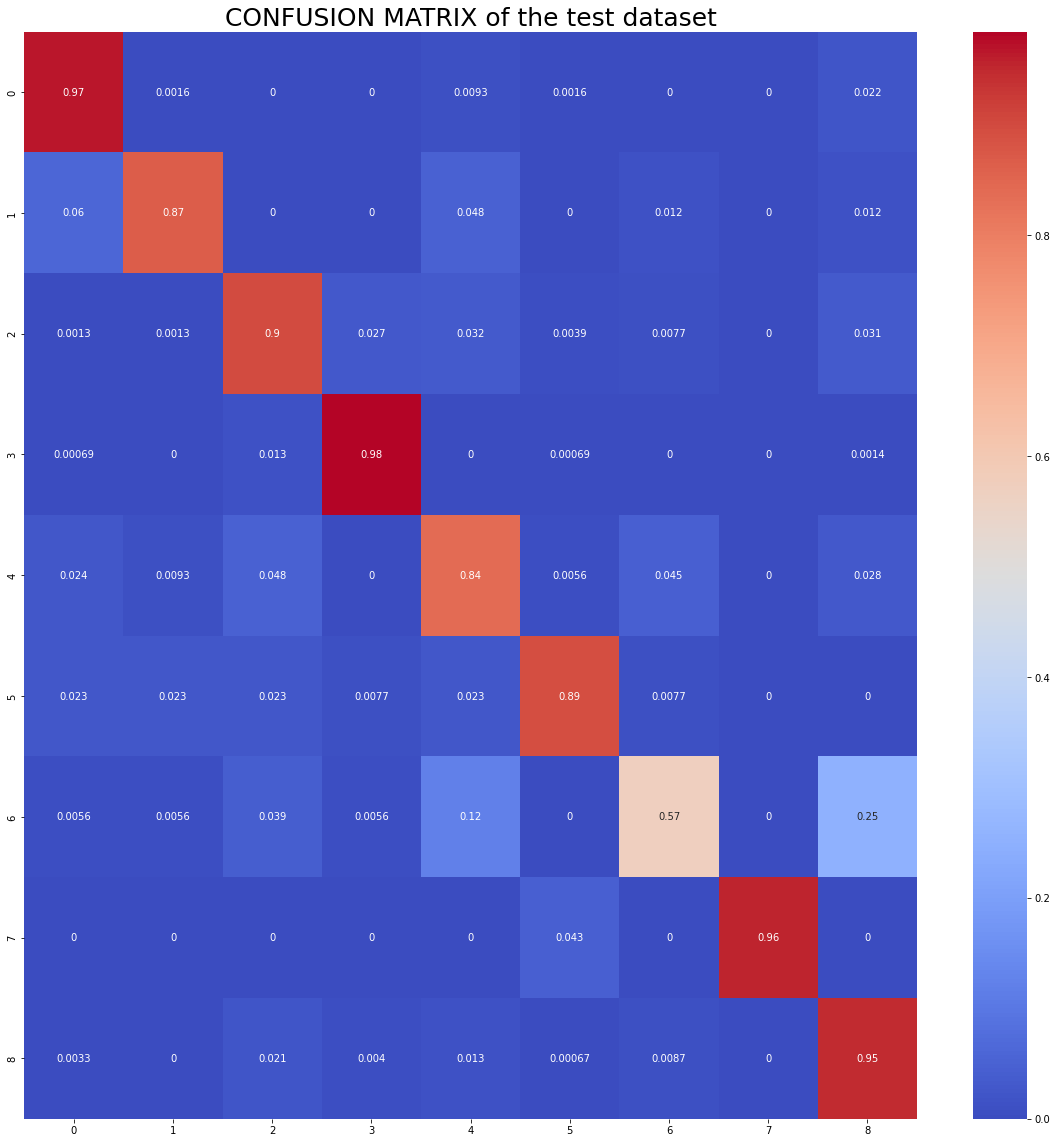

In [13]:
from torchvision.models import resnet50
import torch.nn as nn 
from sklearn.metrics import confusion_matrix

model = resnet50(pretrained=False)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)

# LOAD trained model 
model.load_state_dict(torch.load(save_path))
model.to(device)
test(model, test_loader)